## Imports

In [11]:
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report, roc_auc_score, zero_one_loss
from sklearn_evaluation.plot import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

## Specify directories where prepared data is present and load the data

In [12]:
parent_dir = os.path.dirname(os.getcwd())
training_data_dir = os.path.join(parent_dir,'urban_sound_classification/training_data')

In [58]:
X_train_cnn = np.load(os.path.join(training_data_dir, 'X_train_cnn.npy'))
y_train_cnn = np.load(os.path.join(training_data_dir, 'y_train_cnn.npy'))
X_test_cnn = np.load(os.path.join(training_data_dir, 'X_test_cnn.npy'))
y_test_cnn = np.load(os.path.join(training_data_dir, 'y_test_cnn.npy'))

X_train_rnn = np.load(os.path.join(training_data_dir, 'X_train_rnn.npy'))
y_train_rnn = np.load(os.path.join(training_data_dir, 'y_train_rnn.npy'))
X_test_rnn = np.load(os.path.join(training_data_dir, 'X_test_rnn.npy'))
y_test_rnn = np.load(os.path.join(training_data_dir, 'y_test_rnn.npy'))

X_train_mlp = np.load(os.path.join(training_data_dir, 'X_train_mlp.npy'))
X_test_mlp = np.load(os.path.join(training_data_dir, 'X_test_mlp.npy'))
y_train_mlp = np.load(os.path.join(training_data_dir, 'y_train_mlp.npy'))
y_test_mlp = np.load(os.path.join(training_data_dir, 'y_test_mlp.npy'))

print('CNN:')
print('Train set size:', X_train_cnn.shape[0])
print('Test set size:', X_test_cnn.shape[0])

print('RNN:')
print('Train set size:', X_train_rnn.shape[0])
print('Test set size:', X_test_rnn.shape[0])

print('MLP:')
print('Train set size:', X_train_mlp.shape[0])
print('Test set size:', X_test_mlp.shape[0])

CNN:
Train set size: 37840
Test set size: 16218
RNN:
Train set size: 37840
Test set size: 16218
MLP:
Train set size: 5823
Test set size: 2496


In [59]:
n_labels = y_train_cnn.shape[1]
sound_names = ["air conditioner","car horn","children playing", "dog bark","drilling",
               "engine idling", "gun shot", "jackhammer","siren","street music"]

## Initial settings for CNN and RNN

In [60]:
neur_cnn = 400
frames = 41
cnnbands = 60
n_channels = 2
n_inputs_cnn = X_train_cnn.shape[1]*X_train_cnn.shape[2]

rnnbands = 20
n_steps = 41

k = 'TruncatedNormal' # kernel initializer
batch_size = 100
epochs = 1000
lr_cnn = 1e-4
lr_rnn = 1e-4

In [61]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

## CNN Model

In [62]:
def build_cnn():
    
    model = Sequential()
    
    '''
    48 filters: hidden units which take advantage of the local structure present in the input data.
    (4,4) filter size: process a 4x4 block of pixels of the input space.
    Zero-padding: pad the input volume with zeros around the border.
    (2,2) stride: slide the filters over the input space 2x2 pixels at a time.
    Truncated initialization for weights with L2 regularization.
    (2,2) max pooling: downsampling the number of parameters by taking the max of a 2x2 subregion.
    ReLu activation: apply the non-linear function max(0,x) for each input x. 
    Batchnorm: scales the inputs to have zero mean and unit variance.
    '''
    
    model.add(Conv2D(filters=48, 
                     kernel_size=(4,4), 
                     padding='same',
                     strides=(2,2),
                     kernel_initializer=k,
                     kernel_regularizer=l2(0.01),
                     input_shape=(cnnbands, frames, n_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    # next layer has 96 convolution filters
    model.add(Conv2D(filters=96, 
                     kernel_size=(4,4),
                     strides=(2,2),
                     padding='same',
                     kernel_initializer=k,
                     kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))    
    model.add(BatchNormalization())
    
    # flatten output into a single dimension 
    model.add(Flatten())

    # a FC layer learns non-linear combinations of the features outputted above
    model.add(Dense(neur_cnn, kernel_initializer=k, W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # finally the output layer
    model.add(Dense(n_labels, kernel_initializer=k))
    model.add(Activation('softmax'))

    # optmization
    adam = Adam(lr=lr_cnn)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
    
    return model

cnn = build_cnn()

cnn.summary()

    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 21, 48)        1584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 10, 48)        0         
_________________________________________________________________
activation_17 (Activation)   (None, 15, 10, 48)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 10, 48)        192       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 5, 96)          73824     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 2, 96)          0         
_________________________________________________________________
activation_18 (Activation)   (None, 4, 2, 96)          0         
__________

## Train the CNN and save the model

In [32]:
trained_cnn = cnn.fit(X_train_cnn, 
                      y_train_cnn, 
                      validation_data=(X_test_cnn, y_test_cnn), 
                      callbacks=[earlystop],
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=0)

Epoch 00094: early stopping


In [67]:
history = History()
cnn.save('cnn.h5')

## Visualising the CNN loss

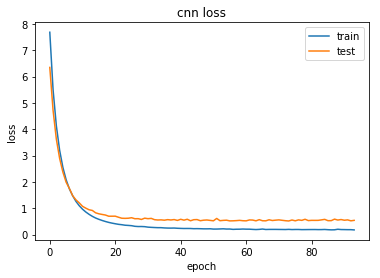

In [34]:
plt.plot(trained_cnn.history['loss'])
plt.plot(trained_cnn.history['val_loss'])
plt.title('cnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Predict on test set and plot confusion matrix

In [71]:
y_prob_cnn = cnn.predict_proba(X_test_cnn, verbose=1)
y_predict_cnn = y_prob_cnn.argmax(axis=-1)

16218/16218 [==============================] - 3s 209us/step


                  precision    recall  f1-score   support

 air conditioner       0.97      0.95      0.96      2097
        car horn       0.99      0.92      0.95       502
children playing       0.77      0.83      0.80      2077
        dog bark       0.90      0.78      0.84      1574
        drilling       0.96      0.91      0.93      1815
   engine idling       0.97      0.97      0.97      2060
        gun shot       0.90      0.85      0.87       238
      jackhammer       0.93      0.97      0.95      1855
           siren       0.95      0.96      0.95      1900
    street music       0.82      0.87      0.84      2100

     avg / total       0.91      0.91      0.91     16218



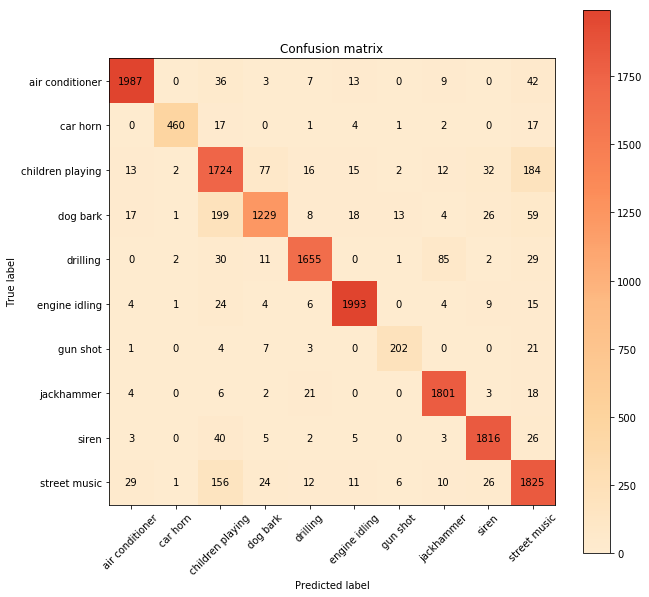

In [43]:
fig = plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
y_true_cnn = np.argmax(y_test_cnn, 1)
confusion_matrix(y_true_cnn, y_predict_cnn, sound_names).grid(False)
print(classification_report(y_true_cnn, y_predict_cnn, None, sound_names))

In [44]:
print('AUCROC:', roc_auc_score(y_test_cnn, y_prob_cnn, average='weighted'))
print('Number of misclassifications:', zero_one_loss(y_true_cnn, y_predict_cnn, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_true_cnn, y_predict_cnn, normalize=True))

AUCROC: 0.9919226766133824
Number of misclassifications: 1526 | Ratio of misclassifications: 0.09409298310519176


## RNN Model

In [63]:
def build_rnn():
    
    model = Sequential()
    
    model.add(LSTM(units=300,
                  dropout=0.1,
                  recurrent_dropout=0.3,
                  return_sequences=True,
                  input_shape=(rnnbands, n_steps)))
    model.add(BatchNormalization())
    
    
    model.add(LSTM(units=75,
                  dropout=0.1,
                  return_sequences=False))
    model.add(BatchNormalization())
    
    
    model.add(Dense(n_labels,
                  kernel_initializer=k,
                  activation='softmax'))
    
    adam = Adam(lr=lr_rnn, epsilon=1e-06)
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

rnn = build_rnn()

rnn.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20, 300)           410400    
_________________________________________________________________
batch_normalization_22 (Batc (None, 20, 300)           1200      
_________________________________________________________________
lstm_8 (LSTM)                (None, 75)                112800    
_________________________________________________________________
batch_normalization_23 (Batc (None, 75)                300       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                760       
Total params: 525,460
Trainable params: 524,710
Non-trainable params: 750
_________________________________________________________________


## Train the RNN and save the model

In [64]:
trained_rnn = rnn.fit(X_train_rnn, 
                      y_train_rnn, 
                      validation_data=(X_test_rnn, y_test_rnn), 
                      callbacks=[earlystop],
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=0)

Epoch 00143: early stopping


In [66]:
history = History()
rnn.save('rnn.h5')

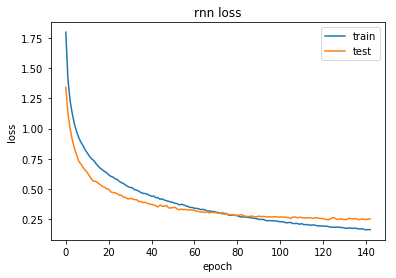

In [68]:
plt.plot(trained_rnn.history['loss'])
plt.plot(trained_rnn.history['val_loss'])
plt.title('rnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Predict on test set and plot confusion matrix

In [70]:
y_prob_rnn = rnn.predict_proba(X_test_rnn, verbose=1)
y_predict_rnn = y_prob_rnn.argmax(axis=-1)

16218/16218 [==============================] - 8s 486us/step


                  precision    recall  f1-score   support

 air conditioner       0.95      0.98      0.96      2097
        car horn       0.91      0.93      0.92       502
children playing       0.84      0.85      0.85      2077
        dog bark       0.90      0.83      0.86      1574
        drilling       0.93      0.95      0.94      1815
   engine idling       0.95      0.98      0.97      2060
        gun shot       0.92      0.94      0.93       238
      jackhammer       0.96      0.97      0.96      1855
           siren       0.96      0.96      0.96      1900
    street music       0.88      0.83      0.85      2100

     avg / total       0.92      0.92      0.92     16218



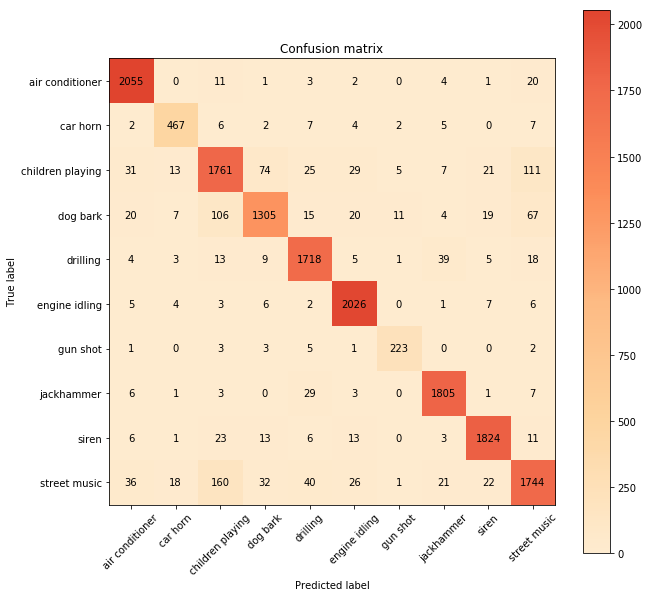

In [72]:
fig = plt.figure(figsize=(10,10))
plt.xticks(rotation=45)
y_true_rnn = np.argmax(y_test_rnn,1)
confusion_matrix(y_true_rnn, y_predict_rnn, sound_names).grid(False)
print(classification_report(y_true_rnn, y_predict_rnn, None, sound_names))

In [73]:
print('AUCROC:', roc_auc_score(y_test_rnn, y_prob_rnn, average='weighted'))
print('Number of misclassifications:', zero_one_loss(y_true_rnn, y_predict_rnn, normalize=False),
      '| Ratio of misclassifications:', zero_one_loss(y_true_rnn, y_predict_rnn, normalize=True))

AUCROC: 0.9951871352368489
Number of misclassifications: 1290 | Ratio of misclassifications: 0.07954125046244909
